In [3]:
import pandas as pd
import osmnx as ox
import networkx as nx
import pylab as plt
import geopandas as gpd
import pandana
import seaborn as sns
import mplleaflet
% pylab inline

/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/nfshome/nj935/.conda/en

Populating the interactive namespace from numpy and matplotlib


/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
city_list = ['Fez','Sale','Rabat', 'Meknes',  'Casablanca',  'Tangier', 'Marrakech','Oujda']

# Identifying critical nodes in city transport networks: Example of Morocco
This notebook downloads road networks from OpenStreetMap, constructs them as graph objects, and finds critical nodes in them. It does this using betweenness centrality, a key metric used in network analysis. For any node X, betweenness centrality (bc) is the fraction of shortest journeys between all other nodes that pass them it. We take advantage of Python libraries that make calculating bc for all nodes in a city's road network quickly. This is a preliminary analysis to demonstrate the method and explore potential uses. These could include:
* comparing the vulnerability of city road networks to disruption;
* seeing whether critical nodes are in flood-prone areas.

#### 1. Get the boundary for each city from OpenStreetMap

In [5]:
def get_city_polygon(city):
    if city in ['Casablanca','Tangier','Marrakech','Oujda']:
        return ox.gdf_from_place(city + ', Morocco', which_result=2)
    else:
        return ox.gdf_from_place(city + ', Morocco')

crs = get_city_polygon('Fez').crs

In [6]:
cities = pd.DataFrame(get_city_polygon('Marrakech'))
for i in [i for i in city_list if i != 'Marrakech']:
    cities = pd.concat([cities,pd.DataFrame(get_city_polygon(i))])
    
cities = gpd.GeoDataFrame(cities,crs = crs)
cities.index = city_list
cities['name'] = city_list

In [7]:
cities

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name
Fez,-7.884739,31.710344,31.544199,-8.089332,"POLYGON ((-8.0893315 31.7008584, -8.0882994 31...","Marrakech ⵎⵕⵕⴰⴽⵯⵛ مراكش, Pachalik de Marrakech...",Fez
Sale,-4.937710,34.075505,33.976428,-5.078179,"POLYGON ((-5.0781791 34.0188682, -5.0727739 34...","Fès ⴼⴰⵙ فاس, Pachalik du Fes, Préfecture de Fè...",Sale
Rabat,-6.690749,34.097487,33.934177,-6.838302,"POLYGON ((-6.8383021 34.0395732, -6.8382593 34...","Salé سلا, Pachalik de Salé, Préfecture de Salé...",Rabat
Meknes,-6.761463,34.037846,33.895629,-6.917435,"(POLYGON ((-6.9174353 33.9620771, -6.9167096 3...","Rabat ⵔⴱⴰⵟ الرباط, pachalik de Rabat, Préfectu...",Meknes
Casablanca,-5.467576,33.923838,33.843865,-5.603964,"POLYGON ((-5.603964 33.8641199, -5.6026518 33....","Meknès ⴰⵎⴽⵏⴰⵙ مكناس, Pachalik de Meknes, Prefe...",Casablanca
Tangier,-7.457416,33.640875,33.493772,-7.746445,"POLYGON ((-7.746445 33.5557435, -7.7439875 33....","Casablanca ⵜⵉⴳⵎⵉ ⵜⵓⵎⵍⵉⵍⵜ الدار البيضاء, préfec...",Tangier
Marrakech,-5.734760,35.820611,35.707880,-5.942243,"(POLYGON ((-5.9422428 35.7454655, -5.9379208 3...","Tanger طنجة, pachalik de Tanger طنجة, Préfectu...",Marrakech
Oujda,-1.851671,34.744153,34.641546,-1.966147,"POLYGON ((-1.9661469 34.6914149, -1.9644077 34...","Oujda وجدة‎, Pachalik d'Oujda باشوية وجدة, Pré...",Oujda


In [8]:
ax = cities.plot()
mplleaflet.display(fig=ax.figure, crs=cities.crs)

### 2. Get road network and compute statistics
For each city, download and simplify the road network through OSMNx.
Compute basic stats and show how the cities compare on intersection density.

In [9]:
def get_graph(geometry):
    return (ox.graph_from_polygon(geometry))

cities['G'] = cities.geometry.apply(get_graph)

In [10]:
def get_stats(G):
    G_proj = ox.project_graph(G)

    # get area covered
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    graph_area_m = nodes_proj.unary_union.convex_hull.area

    # get stats
    stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
        
    return(stats)

cities['stats'] = cities.G.apply(get_stats)

In [11]:
# Extract key stats

cities['intersection_density_km'] = [x.get('intersection_density_km') for x in cities.stats]
cities['street_density_km'] = [x.get('street_density_km') for x in cities.stats]
cities['circuity_avg'] = [x.get('circuity_avg') for x in cities.stats]

In [15]:
cities['nodes'] = [x.get('n') for x in cities.stats]
cities['length'] = [x.get('edge_length_total') for x in cities.stats]

In [14]:
cities.loc['Fez','stats']

{'n': 20585,
 'm': 55147,
 'k_avg': 5.357979111003158,
 'intersection_count': 17362,
 'streets_per_node_avg': 2.882050036434297,
 'streets_per_node_counts': {0: 0,
  1: 3223,
  2: 33,
  3: 13360,
  4: 3896,
  5: 65,
  6: 7,
  7: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.15657031819285888,
  2: 0.001603109059995142,
  3: 0.6490162739859121,
  4: 0.18926402720427496,
  5: 0.003157639057566189,
  6: 0.0003400534369686665,
  7: 4.8579062424095214e-05},
 'edge_length_total': 3710907.514999966,
 'edge_length_avg': 67.29119471594042,
 'street_length_total': 1996269.3140000172,
 'street_length_avg': 67.3368857181413,
 'street_segments_count': 29646,
 'node_density_km': 85.02060356012421,
 'intersection_density_km': 71.70890060776665,
 'edge_density_km': 15326.868918197611,
 'street_density_km': 8245.033856926722,
 'circuity_avg': 1.066962026551855,
 'self_loop_proportion': 0.001976535441637804,
 'clean_intersection_count': 9315,
 'clean_intersection_density_km': 38.473010549553415}

In [56]:
df.group.iloc[1].values[0]

'Sale'

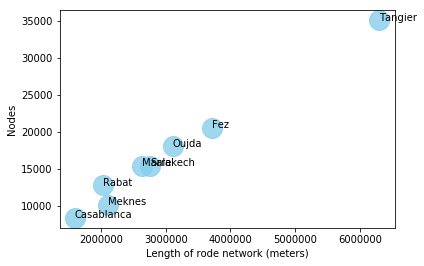

In [76]:
df = cities[['length','nodes','name']]
df.columns = [['x','y','group']]

p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for i in range(0,df.shape[0]):
    p1.text(df.x.iloc[i], df.y.iloc[i], df.group.iloc[i].values[0])
    
p1.set(xlabel='Length of rode network (meters)',ylabel='Nodes');

In [12]:
cities.head(2)

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,name,G,stats,intersection_density_km,street_density_km,circuity_avg
Fez,-7.884739,31.710344,31.544199,-8.089332,"POLYGON ((-8.0893315 31.7008584, -8.0882994 31...","Marrakech ⵎⵕⵕⴰⴽⵯⵛ مراكش, Pachalik de Marrakech...",Fez,"(4411752450, 5352521756, 4246929472, 426967117...","{'n': 20585, 'm': 55147, 'k_avg': 5.3579791110...",71.708901,8245.033857,1.066962
Sale,-4.937710,34.075505,33.976428,-5.078179,"POLYGON ((-5.0781791 34.0188682, -5.0727739 34...","Fès ⴼⴰⵙ فاس, Pachalik du Fes, Préfecture de Fè...",Sale,"(6034751490, 6034751491, 6034751492, 552013006...","{'n': 15359, 'm': 42082, 'k_avg': 5.4797838400...",136.266577,14822.642915,1.052232


In [13]:
### How big are the network objects that we just created?

pd.DataFrame({'City':cities.index, 'Number of nodes (ie. intersections)': [i.number_of_nodes() for i in cities.G]}).sort_values(
                    by='Number of nodes (ie. intersections)',ascending=True).set_index('City').T

City,Casablanca,Meknes,Rabat,Sale,Marrakech,Oujda,Fez,Tangier
Number of nodes (ie. intersections),8335,10084,12752,15359,15368,18047,20585,35121


#### 2.1 Which cities have the densest and least dense street networks??

In [271]:
print("Densest network: {} with {:.1f} intersections per square km.".format(cities.intersection_density_km.idxmax(),cities.intersection_density_km.max()))
print("Least dense network: {} with {:.1f} intersections per square km.".format(cities.intersection_density_km.idxmin(),cities.intersection_density_km.min()))

Densest network: Oujda with 183.9 intersections per square km.
Least dense network: Fez with 71.7 intersections per square km.


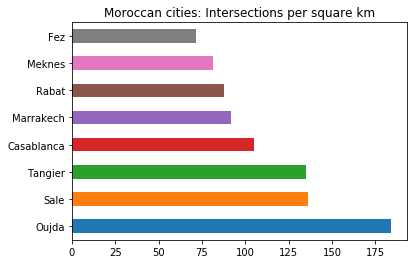

In [266]:
ax = cities.intersection_density_km.sort_values(ascending=False).plot(kind='barh',title='Moroccan cities: Intersections per square km')

#### 2.2 Do some have more indirect street networks than others? (Metric: average circuity)
Average circuity:
* sum of all edge lengths / sum of great circle distances between the nodes they connect.

In [61]:
cities.circuity_avg.sort_values(ascending=True).round(decimals=2)

Oujda         1.04
Casablanca    1.04
Rabat         1.05
Marrakech     1.05
Sale          1.05
Tangier       1.05
Meknes        1.07
Fez           1.07
Name: circuity_avg, dtype: float64

In [47]:
orig = cities.circuity_avg.max()-1
diff = (cities.circuity_avg.max()-1) - (cities.circuity_avg.min()-1)

print("Most circuitous city is {} with average circuity {:.1f} percent higher than {} (the least circuitous city).".format(
    cities.circuity_avg.idxmax(),
    ((orig-diff)/orig*100),
    cities.circuity_avg.idxmin()))

Most circuitous city is Fez with average circuity 57.8 percent higher than Oujda (the least circuitous city).


### 3. Identify critical nodes using betweenness centrality (bc) metric
If you make the shortest path between every node, the betweenness centrality of a node is the proportion of all those paths that have to pass through the node.

#### 3.1 Plot most critical node and show what share of shortest paths run through it

In [51]:
cities['bc'] = [nx.betweenness_centrality(G) for G in cities.G]

In [2]:
cities.head()

NameError: name 'cities' is not defined

In [97]:
def show_most_critical_node(city):
    G = cities.loc[city,'G']
    
    max_node = pd.Series(cities.loc[city,'bc']).idxmax()
    max_value = pd.Series(cities.loc[city,'bc']).max()
    
    nc = ['r' if node==max_node else '#336699' for node in G.nodes()]
    ns = [50 if node==max_node else 8 for node in G.nodes()]
    
    ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=3)
    print("{}: The node with the highest betweenness centrality has {:.1f} percent of shortest joureys running through it.".format(city,max_value*100))

In [ ]:
# Create table of the bc values

df_bc = pd.DataFrame(list(i.values()) for i in cities.bc).T
df_bc.columns = [cities.name]
df_bc.head(2)

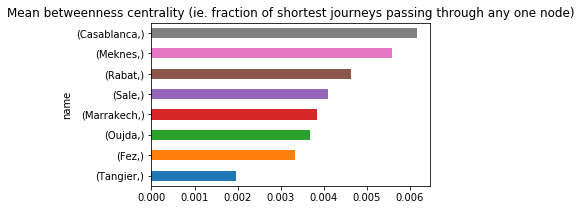

In [282]:
fig=plt.figure(figsize=[5,3])
ax=fig.add_subplot()
df_bc.mean().sort_values().plot(kind='barh',ax=ax)

#### 3.2 Show the distribution of bc values
Do some networks have their shortest paths running through a smaller minority of nodes?

In [148]:
df_bc.describe()

name,Fez,Sale,Rabat,Meknes,Casablanca,Tangier,Marrakech,Oujda
count,20585.000000,15359.000000,12752.000000,10084.000000,8335.000000,35121.000000,15368.000000,18047.000000
mean,0.003328,0.004106,0.004629,0.005594,0.006169,0.001964,0.003834,0.003674
std,0.012290,0.011842,0.012102,0.014206,0.015292,0.007945,0.009831,0.010365
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000080,0.000138,0.000203,0.000269,0.000276,0.000075,0.000166,0.000130
50%,0.000365,0.000520,0.000697,0.001013,0.000959,0.000256,0.000599,0.000442
75%,0.001472,0.002555,0.002818,0.003950,0.004111,0.001011,0.002650,0.001881
max,0.239813,0.202691,0.167406,0.272270,0.199376,0.208536,0.160879,0.145032


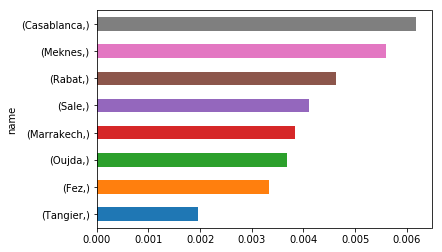

In [276]:
fig,ax=plt.subplots()
df_bc.mean().sort_values(ascending=True).plot(kind='barh',ax=ax)

/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


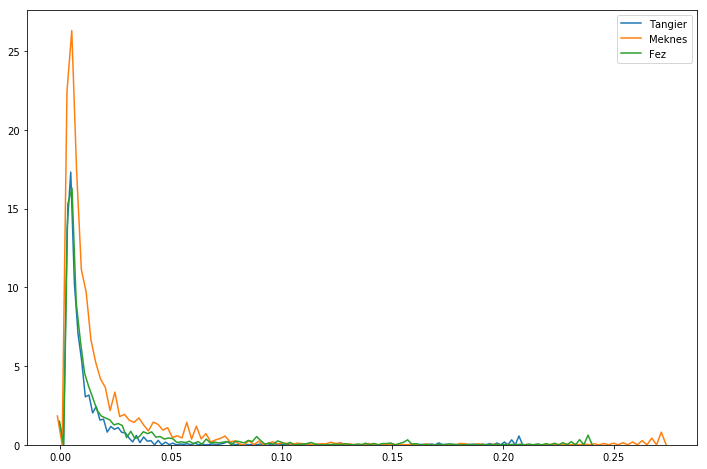

In [145]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot()

for city in ['Tangier','Meknes','Fez']:
    sns.distplot(df_bc[city], norm_hist = True, hist=False, kde = True, label = city, ax=ax)

#### 3.3 Visualize the top 10 percent of nodes by BC

In [268]:
def show_top_percent_nodes(city,percent_nodes_to_show, slippy_map = False):
    G = cities.loc[city,'G']
    gdf = ox.graph_to_gdfs(G,edges=False)
    gdf['bc'] = cities.loc[city,'bc']
    
    threshold = gdf.bc.quantile(1-percent_nodes_to_show)
    
    fig = plt.figure(figsize=[16,6])
    ax = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    gdf.plot(c='w',ax=ax)
    ax.set(facecolor='k',title="{}: All nodes".format(city))
    
    gdf[gdf.bc<threshold].plot(color='w',ax=ax2)
    gdf[gdf.bc>threshold].plot(color='r',alpha=0.7,ax=ax2)
    ax2.set(facecolor='k',title='{}: Top {:.0f}% of nodes by bc'.format(city, percent_nodes_to_show*100))

    gdf.plot(column='bc',cmap='YlOrRd',ax=ax3,legend=True)
    ax3.set(facecolor='k',title='{}: Nodes by bc value'.format(city))
   
    
    plt.show()

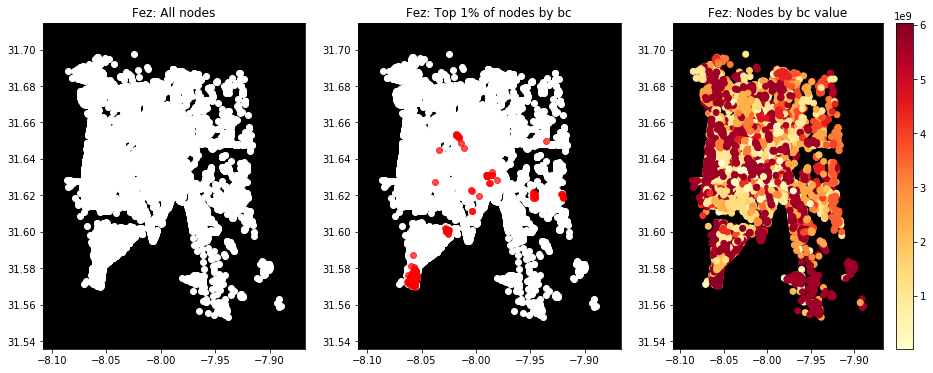

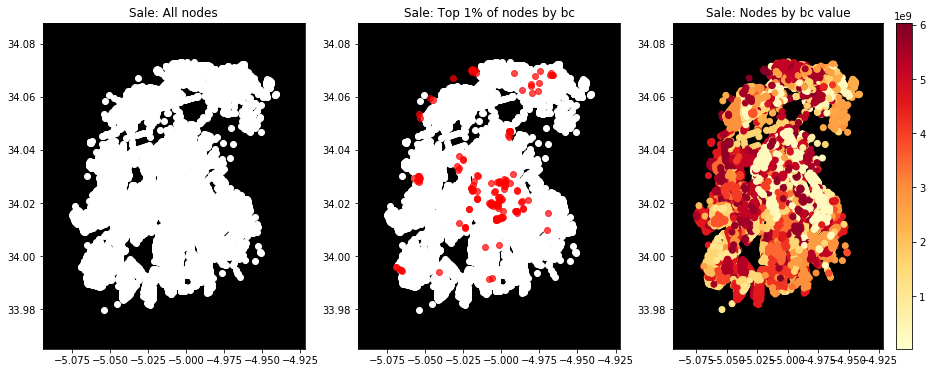

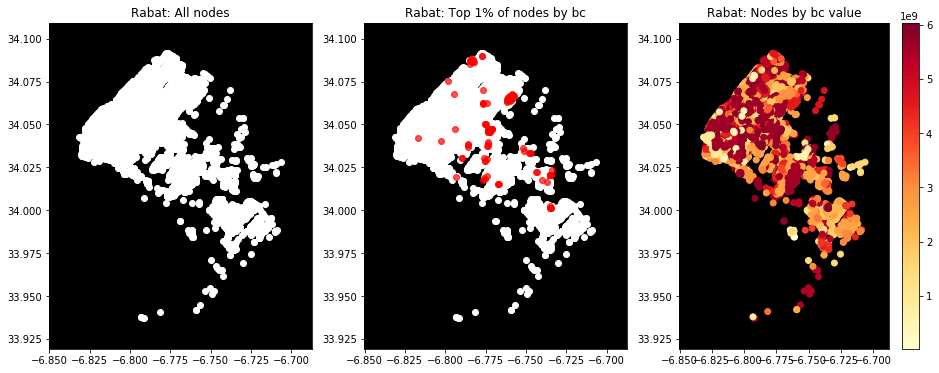

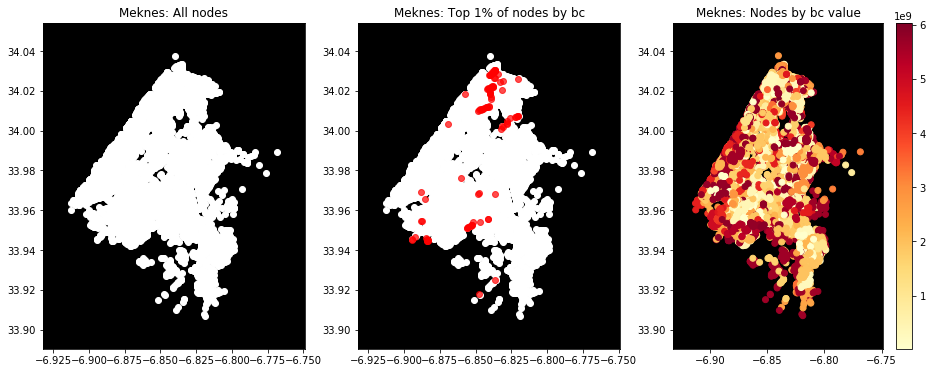

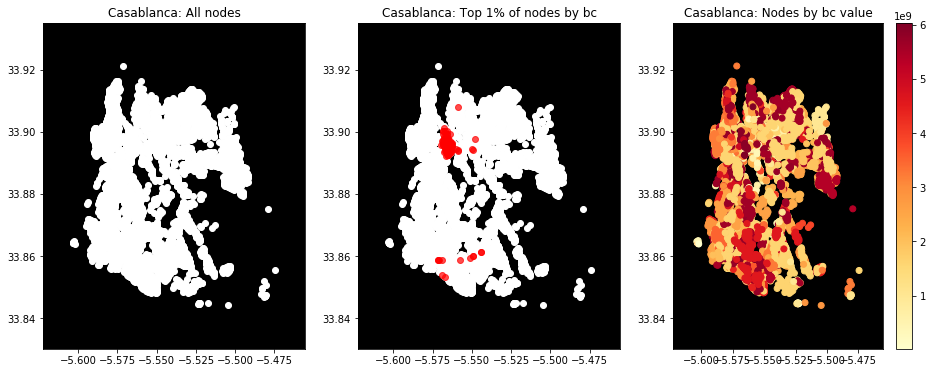

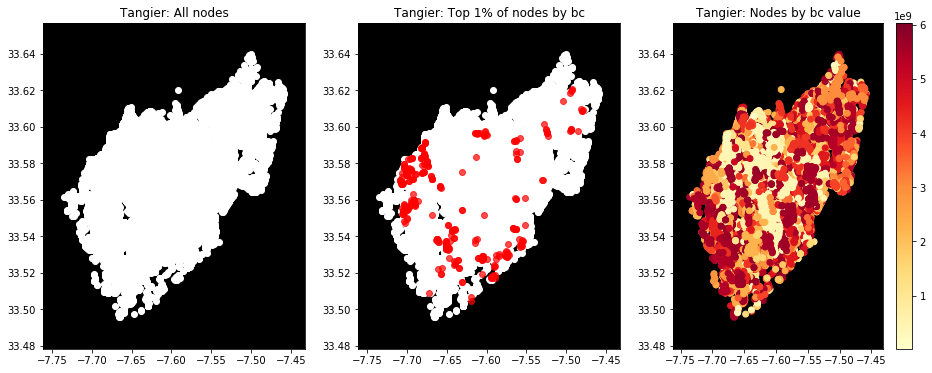

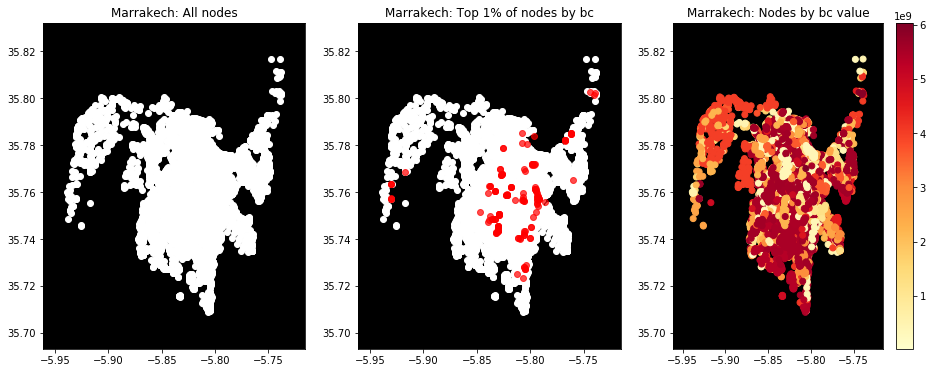

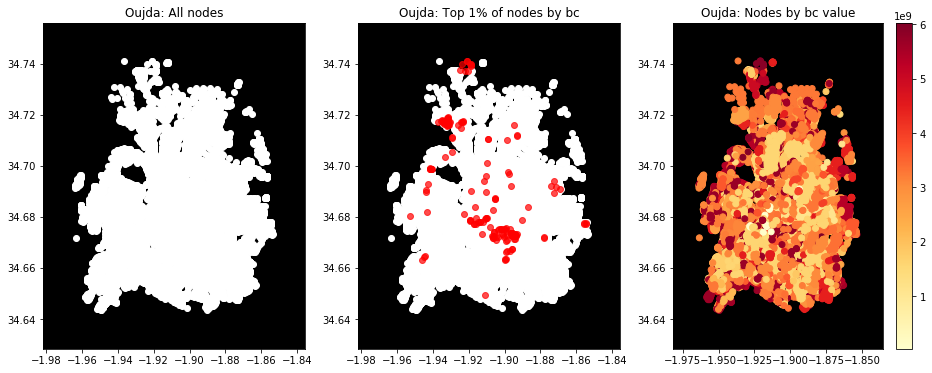

In [269]:
for city in cities.name:
    show_top_percent_nodes(city,0.01)

In [270]:
city,percent_nodes_to_show = 'Meknes',0.01

G = cities.loc[city,'G']
gdf = ox.graph_to_gdfs(G,edges=False)
gdf['bc'] = cities.loc[city,'bc']

threshold = gdf.bc.quantile(1-percent_nodes_to_show)

ax = gdf[gdf.bc>threshold].plot(color='r')
mplleaflet.display(fig=ax.figure, crs=cities.crs)

In [206]:
gdf.to_file('')

Type:        module
String form: <module 'mplleaflet.mplexporter' from '/nfshome/nj935/.conda/envs/monitoring/lib/python3.6/site-packages/mplleaflet/mplexporter/__init__.py'>
File:        ~/.conda/envs/monitoring/lib/python3.6/site-packages/mplleaflet/mplexporter/__init__.py
Docstring:   <no docstring>


In [ ]:
city,percent_nodes_to_show = 'Marrakech',0.005

G = cities.loc[city,'G']
gdf = ox.graph_to_gdfs(G,edges=False)
gdf['bc'] = cities.loc[city,'bc']

threshold = gdf.bc.quantile(1-percent_nodes_to_show)

ax = gdf[gdf.bc>threshold].plot(color='r')
mplleaflet.mplexporter

In [ ]:
# Export shapefile of Casablanca nodes

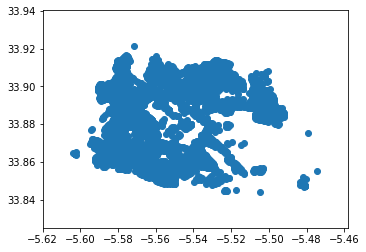

In [80]:
gdf_Casablanca = ox.graph_to_gdfs(cities.loc['Casablanca','G'],edges=False)
gdf_Casablanca.plot()

In [81]:
gdf_Casablanca['bc'] = nx.betweenness_centrality(cities.loc['Casablanca','G'])

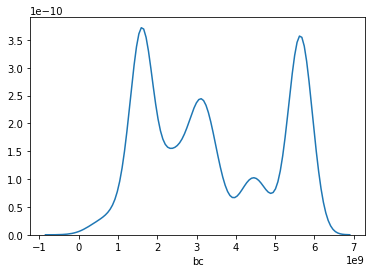

In [88]:
#gdf_Casablanca.bc.hist()
sns.distplot(gdf_Casablanca.bc.dropna(), norm_hist = True, hist=False, kde = True)

In [89]:
gdf_Casablanca.to_file('casa_nodes')

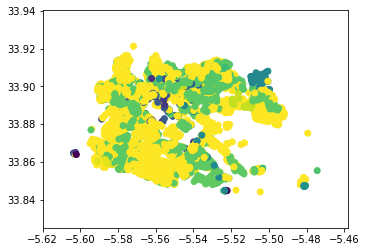

In [90]:
a = gpd.read_file('casa_nodes/casa_nodes.shp')
ax = a.plot(column='bc')